#Section1:Data loading and creating

*Note: This section has already been completed, and the dataset has been prepared. It serves only as a guide to how the dataset was built, so you can proceed directly to Section 2 and skip Section 1.*


In [ ]:
!kaggle datasets download -d fakhrealam9537/leaf-disease-segmentation-dataset

Dataset URL: https://www.kaggle.com/datasets/fakhrealam9537/leaf-disease-segmentation-dataset
License(s): CC0-1.0
100% 501M/503M [00:21<00:00, 18.4MB/s]
100% 503M/503M [00:21<00:00, 24.5MB/s]


In [ ]:
!unzip "/content/leaf-disease-segmentation-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: aug_data/aug_data/images/00411_1.jpg  
  inflating: aug_data/aug_data/images/00411_2.jpg  
  inflating: aug_data/aug_data/images/00411_3.jpg  
  inflating: aug_data/aug_data/images/00411_4.jpg  
  inflating: aug_data/aug_data/images/00412_0.jpg  
  inflating: aug_data/aug_data/images/00412_1.jpg  
  inflating: aug_data/aug_data/images/00412_2.jpg  
  inflating: aug_data/aug_data/images/00412_3.jpg  
  inflating: aug_data/aug_data/images/00412_4.jpg  
  inflating: aug_data/aug_data/images/00413_0.jpg  
  inflating: aug_data/aug_data/images/00413_1.jpg  
  inflating: aug_data/aug_data/images/00413_2.jpg  
  inflating: aug_data/aug_data/images/00413_3.jpg  
  inflating: aug_data/aug_data/images/00413_4.jpg  
  inflating: aug_data/aug_data/images/00414_0.jpg  
  inflating: aug_data/aug_data/images/00414_1.jpg  
  inflating: aug_data/aug_data/images/00414_2.jpg  
  inflating: aug_data/aug_data/images/00414_3.jpg  
  inflating: 

# **Data Augmentation**




**Gaussian Noise - Rotate 90° and 180° - Brightness - Contrast**

In [ ]:
import os
import cv2
import numpy as np
import shutil

# Function to add Gaussian noise to an image
def add_noise(image, mean=0, std_dev=0.66):
    noise = np.random.normal(mean, std_dev, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

# Function to randomly adjust brightness and contrast of an image
def change_brightness_contrast(image, alpha=None, beta=None):
    if alpha is None:
        alpha = np.random.uniform(0.8, 2)  # Random scale factor for brightness
    if beta is None:
        beta = np.random.randint(-60, 60)  # Random offset for contrast
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

# Function to apply augmentations (rotations, noise, brightness/contrast) to an image and mask
def augment_image_and_mask(image, mask):
    augmented_images = [image]
    augmented_masks = [mask]

    # Rotate image and mask 90 degrees
    rotated_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    rotated_mask_90 = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
    augmented_images.append(rotated_90)
    augmented_masks.append(rotated_mask_90)

    # Rotate image and mask 180 degrees
    rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
    rotated_mask_180 = cv2.rotate(mask, cv2.ROTATE_180)
    augmented_images.append(rotated_180)
    augmented_masks.append(rotated_mask_180)

    # Apply noise to the image
    noisy_image = add_noise(image)
    augmented_images.append(noisy_image)
    augmented_masks.append(mask.copy())

    # Apply brightness and contrast adjustment
    bright_contrast_image = change_brightness_contrast(image)
    augmented_images.append(bright_contrast_image)
    augmented_masks.append(mask.copy())

    return augmented_images, augmented_masks

# Paths to original and augmented image/mask directories
image_dir = '/content/data/data/images/'
mask_dir = '/content/data/data/masks/'
aug_image_dir = 'augment_data_img4'
aug_mask_dir = 'augment_data_mask4'
combined_aug_dir = 'combined_augmented_data4'
zip_dir = 'augmented_data4.zip'

# Create directories for augmented images and masks
os.makedirs(aug_image_dir, exist_ok=True)
os.makedirs(aug_mask_dir, exist_ok=True)
os.makedirs(combined_aug_dir, exist_ok=True)

# Get list of all image and mask files
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(('.jpg', '.png'))]

# Check if the count of images and masks match
if len(image_files) != len(mask_files):
    raise ValueError("The number of images and masks must be equal.")

# Apply augmentation for each image and corresponding mask
for img_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        raise ValueError(f"Error loading image at {image_path}")
    if mask is None:
        raise ValueError(f"Error loading mask at {mask_path}")

    # Generate augmented versions of image and mask
    augmented_images, augmented_masks = augment_image_and_mask(image, mask)

    # Save each augmented image and mask
    for i, (aug_img, aug_mask) in enumerate(zip(augmented_images, augmented_masks)):
        output_img_path = os.path.join(aug_image_dir, f'augmented_{img_file[:-4]}_{i}.jpg')
        output_mask_path = os.path.join(aug_mask_dir, f'augmented_{mask_file[:-4]}_{i}.png')
        cv2.imwrite(output_img_path, aug_img)
        cv2.imwrite(output_mask_path, aug_mask)
        print(f'Image and mask saved: {output_img_path}, {output_mask_path}')

# Copy augmented data to combined directory for easier access
shutil.copytree(aug_image_dir, os.path.join(combined_aug_dir, 'images'))
shutil.copytree(aug_mask_dir, os.path.join(combined_aug_dir, 'masks'))

# Compress the combined augmented data into a zip file
shutil.make_archive(zip_dir[:-4], 'zip', root_dir='.', base_dir=combined_aug_dir)

# Print the total number of augmented images and masks created
num_aug_images = len(os.listdir(aug_image_dir))
num_aug_masks = len(os.listdir(aug_mask_dir))

print(f'Total augmented images: {num_aug_images}')
print(f'Total augmented masks: {num_aug_masks}')


# **build train and val directories**

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths to the original directories of images and masks
image_dir = '/content/combined_augmented_data4/images/'
mask_dir = '/content/combined_augmented_data4/masks/'

# Directory for organized train and validation sets
output_dir = 'augmented_data'

# Define subdirectories for training and validation images and masks
train_images_dir = os.path.join(output_dir, 'train_images')
train_masks_dir = os.path.join(output_dir, 'train_masks')
val_images_dir = os.path.join(output_dir, 'valid_images')
val_masks_dir = os.path.join(output_dir, 'valid_masks')

# Create directories for training and validation data if they don’t exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_masks_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_masks_dir, exist_ok=True)

# List of image and mask files, sorted to ensure alignment between pairs
images = sorted(os.listdir(image_dir))
masks = sorted(os.listdir(mask_dir))

# Check that the number of images matches the number of masks
assert len(images) == len(masks)

# Split data into training (80%) and validation (20%) sets
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

# Function to copy files from a source directory to a destination directory
def copy_files(file_list, source_dir, destination_dir):
    for file_name in file_list:
        shutil.copy(os.path.join(source_dir, file_name), destination_dir)

# Copy training images and masks to their respective directories
copy_files(train_images, image_dir, train_images_dir)
copy_files(train_masks, mask_dir, train_masks_dir)

# Copy validation images and masks to their respective directories
copy_files(val_images, image_dir, val_images_dir)
copy_files(val_masks, mask_dir, val_masks_dir)


# **Data Seperation**

In [ ]:
import os
import shutil
import random

# Base directory containing all data
DATA_DIR = '/content/augmented_data/'

# Define directories for training images and masks
train_images = os.path.join(DATA_DIR, 'train_images')
train_masks = os.path.join(DATA_DIR, 'train_masks')

# Display initial counts of images and masks in the training directory
print("Before Splitting the train and test")
print(len(os.listdir(train_images)))
print(len(os.listdir(train_masks)))

# Define directories for testing and validation images and masks
test_images = os.path.join(DATA_DIR, 'test_images')
test_masks = os.path.join(DATA_DIR, 'test_masks')
valid_images = os.path.join(DATA_DIR, 'valid_images')
valid_masks = os.path.join(DATA_DIR, 'valid_masks')

# Create test directories if they don't exist
os.makedirs(test_images, exist_ok=True)
os.makedirs(test_masks, exist_ok=True)

# Get lists of images and masks, sorted to keep them in corresponding order
image_files = os.listdir(train_images)
mask_files = os.listdir(train_masks)
image_files.sort()
mask_files.sort()

# Ensure the same number of images and masks
assert len(image_files) == len(mask_files)

# Calculate the number of samples to move to the test set (10% of data)
num_test_samples = int(len(image_files) * 0.1)

# Randomly select indices for test samples
test_indices = random.sample(range(len(image_files)), num_test_samples)

# Move selected images and masks to the test directories
for i in test_indices:
    image_file = image_files[i]
    mask_file = mask_files[i]

    image_src = os.path.join(train_images, image_file)
    image_dest = os.path.join(test_images, image_file)

    mask_src = os.path.join(train_masks, mask_file)
    mask_dest = os.path.join(test_masks, mask_file)

    shutil.move(image_src, image_dest)
    shutil.move(mask_src, mask_dest)

# Print the total number of files moved to the test set
print(f"Moved {num_test_samples} images and masks to the test set.")


# **Section2:Library import and installation and Gdrive connect**

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

**`segmentation-models-pytorch` is a PyTorch-based library that provides implementations of cutting-edge image segmentation architectures such as U-Net, DeepLabV3+, and FPN. It includes support for pre-trained models, various loss functions, and evaluation metrics, making it easier to develop and optimize segmentation tasks.**

In [ ]:
!pip install gdown

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import os, cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from torch.utils.tensorboard import SummaryWriter
import datetime
import matplotlib.pyplot as plt
import albumentations as album
import random

# **the main dataset for testing all models**

**connect to GDrive for saving model weights**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**import the main Build for testing model outputs**

In [ ]:
!gdown --id 1qoadjw0j-_ZMDOJ-OvC7gL9jFDooGDCA

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1qoadjw0j-_ZMDOJ-OvC7gL9jFDooGDCA
From (redirected): https://drive.google.com/uc?id=1qoadjw0j-_ZMDOJ-OvC7gL9jFDooGDCA&confirm=t&uuid=093e851c-4d6f-4e03-a927-7d5ecef03ab1
To: /content/dataset.zip
100% 709M/709M [00:16<00:00, 44.0MB/s]


In [ ]:
!unzip "/content/dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: augmented_data/train_images/augmented_00314_2.jpg  
  inflating: augmented_data/train_images/augmented_00363_2.jpg  
  inflating: augmented_data/train_images/augmented_00360_1.jpg  
  inflating: augmented_data/train_images/augmented_00134_3.jpg  
  inflating: augmented_data/train_images/augmented_00504_0.jpg  
  inflating: augmented_data/train_images/augmented_00549_4.jpg  
  inflating: augmented_data/train_images/augmented_00500_0.jpg  
  inflating: augmented_data/train_images/augmented_00468_4.jpg  
  inflating: augmented_data/train_images/augmented_00296_2.jpg  
  inflating: augmented_data/train_images/augmented_00552_3.jpg  
  inflating: augmented_data/train_images/augmented_00579_4.jpg  
  inflating: augmented_data/train_images/augmented_00483_0.jpg  
  inflating: augmented_data/train_images/augmented_00482_2.jpg  
  inflating: augmented_data/train_images/augmented_00584_0.jpg  
  inflating: augmented_data/train_image

In [ ]:
train_images="/content/augmented_data/train_images/"
train_masks="/content/augmented_data/train_masks/"
test_images ="/content/augmented_data/test_images/"
test_masks="/content/augmented_data/test_masks/"
valid_images="/content/augmented_data/valid_images/"
valid_masks="/content/augmented_data/valid_masks/"

# **To check RGB class in binary masked image**

In [ ]:
import numpy as np
from PIL import Image

# Function to find unique RGB colors in an image
def find_unique_colors(image_path):
    # Open the image, convert it to RGB mode to ensure it's in 3 channels
    image = Image.open(image_path).convert('RGB')

    # Convert the image to a numpy array
    image_array = np.array(image)

    # Reshape the image array to a 2D array (flatten the image) and find unique colors (by axis 0, each color is a row)
    unique_colors = np.unique(image_array.reshape(-1, image_array.shape[2]), axis=0)

    # Convert the unique colors (rows) into tuples for readability
    unique_colors_list = [tuple(color) for color in unique_colors]

    return unique_colors_list

# Define the path to the image you want to analyze
image_path = test_masks + '/augmented_00016_1.png'

# Call the function to find unique colors
unique_colors = find_unique_colors(image_path)

# Initialize a list to store color information
color = []

# Print out the unique RGB colors and assign each one to a class
print("Unique RGB colors in the image:")
for idx, color in enumerate(unique_colors):
    print(f"Class {idx}: {color}")


In [ ]:
print(len(os.listdir(train_images)))
print(len(os.listdir(train_masks)))
print(len(os.listdir(test_images)))
print(len(os.listdir(test_masks)))
print(len(os.listdir(valid_images)))
print(len(os.listdir(valid_masks)))

2117
2117
235
235
588
588


# **Set Classes**

In [ ]:
class_names = ['background','affected']
class_rgb_values = [[0, 0, 0], color]

select_classes = class_names

select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'affected']
Class RGB values:  [[0, 0, 0], (38, 38, 38)]


# **Custom Class for Pre Process**

# **visualizer**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize multiple images in one plot
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20, 8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)  # Place each image in a subplot
        plt.xticks([])  # Remove x-axis ticks
        plt.yticks([])  # Remove y-axis ticks
        plt.title(name.replace('_', ' ').title(), fontsize=20)  # Title for each image
        plt.imshow(image)  # Display image
    plt.show()

# Function for one-hot encoding of segmentation labels
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        # Check for equality between the image label and the current class color
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis=-1)  # All channels must match
        semantic_map.append(class_map)

    # Stack all class maps to form a one-hot encoded image (each class in its own channel)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Function to reverse one-hot encoding and convert back to the original label values
def reverse_one_hot(image):
    x = np.argmax(image, axis=-1)  # Find index of the maximum value along channels
    return x

# Function to apply colour coding to segmented images
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    # Convert the image indices into corresponding RGB color values
    x = colour_codes[image.astype(int)]

    # Add an alpha channel for transparency
    if x.shape[2] == 3:
        x_with_alpha = np.dstack([x, np.ones((x.shape[0], x.shape[1]), dtype=np.uint8) * 255])
    else:
        x_with_alpha = x

    # Masks for black and grey pixels
    black_mask = (x[:, :, 0] == 0) & (x[:, :, 1] == 0) & (x[:, :, 2] == 0)
    grey_mask = (x[:, :, 0] == 38) & (x[:, :, 1] == 38) & (x[:, :, 2] == 38)

    # Modify alpha for black pixels (make them fully transparent)
    x_with_alpha[black_mask, 3] = 0
    # Modify color for grey pixels (turn them to blue)
    x_with_alpha[grey_mask, 0] = 0  # Red channel to 0
    x_with_alpha[grey_mask, 1] = 0  # Green channel to 0
    x_with_alpha[grey_mask, 2] = 255  # Blue channel to 255
    return x_with_alpha

import cv2

# Function to overlay ground truth mask on the original image
def overlay_ground_truth(original_image, ground_truth_mask):
    # If the original image is grayscale, convert it to RGB
    if original_image.shape[2] == 1:
        original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)

    # Resize the ground truth mask to match the size of the original image if necessary
    if ground_truth_mask.shape[:2] != original_image.shape[:2]:
        ground_truth_mask = cv2.resize(ground_truth_mask, (original_image.shape[1], original_image.shape[0]))

    # Add an alpha channel to the ground truth mask if it doesn't already have one
    if ground_truth_mask.shape[2] == 3:
        ground_truth_mask = np.dstack([ground_truth_mask, np.ones((ground_truth_mask.shape[0], ground_truth_mask.shape[1]), dtype=np.uint8) * 255])

    # Create a copy of the original image to overlay the mask
    overlay_image = original_image.copy()

    # Loop through each pixel and apply the mask (only pixels with non-zero alpha are modified)
    for y in range(original_image.shape[0]):
        for x in range(original_image.shape[1]):
            if ground_truth_mask[y, x, 3] > 0:
                overlay_image[y, x] = ground_truth_mask[y, x, :3]  # Apply the mask's RGB values

    return overlay_image


# **Plant Dataset class**

In [ ]:
import os
import cv2
import torch

# Custom dataset class for plant disease segmentation
class PlantDiseaseDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,  # Class RGB values for one-hot encoding
            augmentation=None,  # Optional data augmentation pipeline
            preprocessing=None,  # Optional preprocessing pipeline
    ):
        # Get list of all image and mask file paths
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        # Store class RGB values, augmentation, and preprocessing functions
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # Read the image and mask files
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)  # Convert image to RGB
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)  # Convert mask to RGB

        # Resize image and mask to a fixed size (256x256)
        image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # One-hot encode the mask based on class RGB values
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # Apply augmentations (if provided)
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Apply preprocessing (if provided)
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Return the processed image and mask
        return image, mask

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.image_paths)


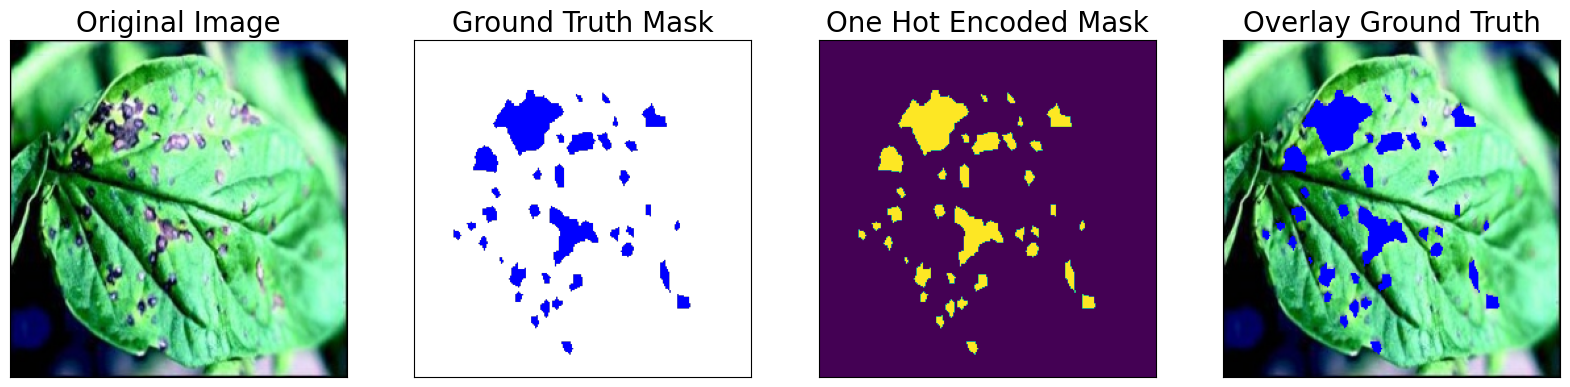

In [ ]:
dataset = PlantDiseaseDataset(train_images, train_masks, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]
ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values)

visualize(
    original_image = image,
    ground_truth_mask =colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values) ,
    one_hot_encoded_mask = reverse_one_hot(mask),
    overlay_ground_truth=overlay_ground_truth(image,ground_truth_mask)

)

# **Augmented Image**

**NOTE:Augmentation has been done Before so the p is 0**

In [ ]:
# Function to apply data augmentation techniques during training
def get_training_augmentation():
    train_transform = [
        album.OneOf(
            [  # Apply one of the following transformations randomly
                album.HorizontalFlip(p=1),   # Horizontal flip with 100% probability
                album.VerticalFlip(p=1),     # Vertical flip with 100% probability
                album.RandomRotate90(p=1),   # Random 90-degree rotation with 100% probability
            ],
            p=0.0,  # Set the probability of applying this block to 0 (i.e., no augmentation)
        ),
    ]
    return album.Compose(train_transform)  # Return the composed transformations for training

# Function to apply padding during validation to ensure the image dimensions are divisible by 32
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        album.PadIfNeeded(
            min_height=256,               # Ensure the image height is at least 256
            min_width=256,                # Ensure the image width is at least 256
            always_apply=True,            # Always apply this transformation
            border_mode=0,                # Use constant padding (black padding)
            value=0                        # Black padding color (0)
        ),
    ]
    return album.Compose(test_transform)  # Return the composed transformations for validation

# Function to convert image and mask to tensor format for PyTorch
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')  # Transpose image channels to CxHxW format and convert to float32

# Function to return preprocessing transformations that apply the given function
def get_preprocessing(preprocessing_fn=None):
    _transform = []  # List to store transformations
    if preprocessing_fn:  # If a preprocessing function is provided
        _transform.append(album.Lambda(image=preprocessing_fn))  # Apply the custom preprocessing function
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))  # Convert image and mask to tensor format

    return album.Compose(_transform)  # Return the composed preprocessing transformations


In [ ]:
# Create an augmented dataset with training images and masks, applying the defined augmentation techniques
augmented_dataset = PlantDiseaseDataset(
    train_images, train_masks,
    augmentation=get_training_augmentation(),  # Apply training augmentations
    class_rgb_values=select_class_rgb_values,  # RGB values for classes in the segmentation mask
)

# Randomly select an index from the augmented dataset
random_idx = random.randint(0, len(augmented_dataset)-1)
print(len(augmented_dataset))  # Print the length of the augmented dataset for verification

# Loop through a single sample for visualization
for i in range(1):
    # Get the image and its corresponding mask from the dataset
    image, mask = augmented_dataset[random_idx]

    # Generate the ground truth mask by converting the one-hot encoded mask to RGB colors
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values)

    # Visualize the image along with the ground truth and one-hot encoded mask
    visualize(
        original_image=image,  # The original image
        ground_truth_mask=ground_truth_mask,  # The ground truth mask in RGB
        one_hot_encoded_mask=reverse_one_hot(mask),  # The one-hot encoded mask
        overlay_ground_truth=overlay_ground_truth(image, ground_truth_mask)  # Overlay the ground truth mask on the image
    )

# **Model Architecture**

In [ ]:
import segmentation_models_pytorch as smp


# **model in essay**



**FPN+efficientnet-b0**

*FPN (Feature Pyramid Network) combined with EfficientNet-B0 leverages EfficientNet's efficient architecture for feature extraction while utilizing FPN's multi-scale feature fusion for improved performance in tasks like object detection and segmentation.*








In [ ]:
import segmentation_models_pytorch as smp

model = smp.FPN(
    encoder_name='efficientnet-b0',
    encoder_depth=3,
    encoder_weights='imagenet',
    decoder_pyramid_channels=256,
    decoder_segmentation_channels=128,
    decoder_merge_policy='add',
    in_channels=3,
    classes=2,
    activation='sigmoid',
    upsampling=1
)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 90.2MB/s]


**MA-Net**

*MA-Net (Multi-Attention Network) enhances image segmentation by integrating multiple attention mechanisms, improving feature extraction and segmentation accuracy.*


In [ ]:
import segmentation_models_pytorch as smp

model = smp.MAnet(
    encoder_weights='imagenet',
    decoder_channels=(256, 128, 64, 32, 16),
    decoder_pab_channels=64,
    in_channels=3,
    classes=2,
    activation='sigmoid'
)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 147MB/s]


**Linknet**

*LinkNet is a semantic segmentation model that combines an encoder-decoder structure with efficient skip connections, optimizing both performance and inference speed.*

In [ ]:
model = smp.Linknet(
    encoder_weights='imagenet',
    in_channels=3,
    classes=2,
    activation='sigmoid'
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 115MB/s]


**PSPNet**

*PSPNet (Pyramid Scene Parsing Network) enhances semantic segmentation by leveraging a pyramid pooling module that captures contextual information across multiple scales to improve segmentation accuracy in complex scenes.*

In [ ]:
model = smp.PSPNet(
    encoder_weights='imagenet',
    encoder_depth=3,
    psp_out_channels=512,
    in_channels=3,
    classes=2,
    activation='sigmoid',
    upsampling=8
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 395MB/s]


**Deeplabv3+**

*Deeplabv3+ is an advanced deep learning model for semantic segmentation, enhancing the original Deeplabv3 with a depthwise separable convolutional decoder to better capture spatial details and improve performance on pixel-level segmentation tasks.*

In [ ]:
model = smp.DeepLabV3Plus(
    encoder_weights='imagenet',
    in_channels=3,
    classes=2,
    activation='sigmoid',
)

# **SCSE Mechanism**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Channel Attention Layer (cSE)
class ChannelSELayer(nn.Module):
    def __init__(self, num_channels, reduction_ratio=2):
        # Initialization of layers for channel attention (Squeeze-and-Excitation)
        super(ChannelSELayer, self).__init__()
        num_channels_reduced = num_channels // reduction_ratio  # Reduced channels for FC layer
        self.reduction_ratio = reduction_ratio
        self.fc1 = nn.Linear(num_channels, num_channels_reduced, bias=True)  # Fully connected layer 1
        self.fc2 = nn.Linear(num_channels_reduced, num_channels, bias=True)  # Fully connected layer 2
        self.relu = nn.ReLU()  # Activation function
        self.sigmoid = nn.Sigmoid()  # Activation function for scaling channels

    def forward(self, input_tensor):
        batch_size, num_channels, H, W = input_tensor.size()  # Get input tensor dimensions
        # Squeeze operation: average pooling over channels
        squeeze_tensor = input_tensor.view(batch_size, num_channels, -1).mean(dim=2)

        # Excitation: FC layers to learn importance of channels
        fc_out_1 = self.relu(self.fc1(squeeze_tensor))  # Apply first FC layer + ReLU
        fc_out_2 = self.sigmoid(self.fc2(fc_out_1))  # Apply second FC layer + Sigmoid for scaling

        a, b = squeeze_tensor.size()
        output_tensor = torch.mul(input_tensor, fc_out_2.view(a, b, 1, 1))  # Rescale input tensor
        return output_tensor

# Spatial Attention Layer (sSE)
class SpatialSELayer(nn.Module):
    def __init__(self, num_channels):
        super(SpatialSELayer, self).__init__()
        self.conv = nn.Conv2d(num_channels, 1, 1)  # 1x1 convolution to learn spatial attention
        self.sigmoid = nn.Sigmoid()  # Sigmoid for excitation

    def forward(self, input_tensor, weights=None):
        batch_size, channel, a, b = input_tensor.size()  # Get input tensor dimensions

        # If weights are provided, compute weighted sum over channels
        if weights is not None:
            weights = torch.mean(weights, dim=0)  # Take mean of weights
            weights = weights.view(1, channel, 1, 1)  # Reshape for convolution
            out = F.conv2d(input_tensor, weights)  # Apply convolution
        else:
            out = self.conv(input_tensor)  # Otherwise apply the learnable convolution

        squeeze_tensor = self.sigmoid(out)  # Apply sigmoid to get spatial attention map

        # Excitation: Rescale the input tensor by the attention map
        squeeze_tensor = squeeze_tensor.view(batch_size, 1, a, b)
        output_tensor = torch.mul(input_tensor, squeeze_tensor)  # Apply spatial excitation
        return output_tensor

# Combined Channel + Spatial Attention Layer (cSE + sSE)
class ChannelSpatialSELayer(nn.Module):
    def __init__(self, num_channels, reduction_ratio=2):
        super(ChannelSpatialSELayer, self).__init__()
        self.cSE = ChannelSELayer(num_channels, reduction_ratio)  # Channel SE
        self.sSE = SpatialSELayer(num_channels)  # Spatial SE

    def forward(self, input_tensor):
        # Combine channel and spatial attention
        # Alternative: Could use max instead of sum for combination
        output_tensor = self.cSE(input_tensor) + self.sSE(input_tensor)
        return output_tensor


**My model**

In [ ]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
    activation='sigmoid',
    decoder_attention_type='scse'
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 344MB/s]


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Train and Validation Instance**

In [ ]:
import segmentation_models_pytorch.utils

In [ ]:
# Get train and val dataset instances
train_dataset = PlantDiseaseDataset(
    train_images, train_masks,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = PlantDiseaseDataset(
    valid_images, valid_masks,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# **Hyper Parameter Tunning**

In [ ]:
# Flag to control if training is enabled
TRAINING = True

# Number of training epochs (iterations over the entire dataset)
EPOCHS = 35

# Set the device for training (CUDA if available, otherwise CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss function: DiceLoss is commonly used for segmentation tasks to measure overlap between predicted and true masks
loss = smp.utils.losses.DiceLoss()

# Metrics to evaluate the model's performance, using IoU (Intersection over Union) with a threshold of 0.5
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# Optimizer: Adam optimizer is used for efficient training with an initial learning rate of 0.0001
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),  # Specify the parameters of the model and the learning rate
])

# Learning Rate Scheduler: CosineAnnealingWarmRestarts adjusts the learning rate during training to improve performance
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,   # The optimizer whose learning rate will be adjusted
    T_0=1,       # Initial number of iterations for the first restart
    T_mult=2,    # Multiplier for the period length after each restart
    eta_min=5e-5,  # Minimum learning rate
)


# **Choose the model  weights Path**

In [ ]:
m_path = '/content/drive/MyDrive/my model.pth'

if os.path.exists(m_path):
    model = torch.load(m_path, map_location=DEVICE)

In [ ]:
# Set up the training epoch with loss, metrics, and optimizer
train_epoch = smp.utils.train.TrainEpoch(
    model, loss=loss, metrics=metrics, optimizer=optimizer, device=DEVICE, verbose=True
)

# Set up the validation epoch with loss, metrics, and device
valid_epoch = smp.utils.train.ValidEpoch(
    model, loss=loss, metrics=metrics, device=DEVICE, verbose=True
)


# **Models Training**

**efficientnet-b0+FPN**

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, m_path)
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 588/588 [00:24<00:00, 23.70it/s, dice_loss - 0.1271, iou_score - 0.7909]
Model saved!

Epoch: 1
valid: 100%|██████████| 588/588 [00:22<00:00, 25.72it/s, dice_loss - 0.1219, iou_score - 0.7981]
Model saved!

Epoch: 2
valid: 100%|██████████| 588/588 [00:25<00:00, 22.96it/s, dice_loss - 0.1196, iou_score - 0.8005]
Model saved!

Epoch: 3
valid: 100%|██████████| 588/588 [00:23<00:00, 25.00it/s, dice_loss - 0.117, iou_score - 0.8035]
Model saved!

Epoch: 4
valid: 100%|██████████| 588/588 [00:26<00:00, 22.54it/s, dice_loss - 0.1149, iou_score - 0.8062]
Model saved!

Epoch: 5
valid: 100%|██████████| 588/588 [00:24<00:00, 24.27it/s, dice_loss - 0.1142, iou_score - 0.8078]
Model saved!

Epoch: 6
valid: 100%|██████████| 588/588 [00:23<00:00, 25.33it/s, dice_loss - 0.1138, iou_score - 0.8061]

Epoch: 7
valid: 100%|██████████| 588/588 [00:24<00:00, 23.79it/s, dice_loss - 0.08668, iou_score - 0.8528]
Model saved!

Epoch: 8
valid: 100%|██████████| 588/588 [00:22<00:0

**MA-Net**

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, m_path)
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 588/588 [00:18<00:00, 31.52it/s, dice_loss - 0.1365, iou_score - 0.8517]
Model saved!

Epoch: 1
valid: 100%|██████████| 588/588 [00:18<00:00, 31.51it/s, dice_loss - 0.0963, iou_score - 0.8705]
Model saved!

Epoch: 2
valid: 100%|██████████| 588/588 [00:18<00:00, 31.69it/s, dice_loss - 0.08045, iou_score - 0.8783]
Model saved!

Epoch: 3
valid: 100%|██████████| 588/588 [00:19<00:00, 30.91it/s, dice_loss - 0.07217, iou_score - 0.8851]
Model saved!

Epoch: 4
valid: 100%|██████████| 588/588 [00:18<00:00, 31.45it/s, dice_loss - 0.065, iou_score - 0.8926]
Model saved!

Epoch: 5
valid: 100%|██████████| 588/588 [00:19<00:00, 30.82it/s, dice_loss - 0.06051, iou_score - 0.8976]
Model saved!

Epoch: 6
valid: 100%|██████████| 588/588 [00:18<00:00, 32.37it/s, dice_loss - 0.05797, iou_score - 0.9012]
Model saved!

Epoch: 7
valid: 100%|██████████| 588/588 [00:18<00:00, 32.45it/s, dice_loss - 0.078, iou_score - 0.8684]

Epoch: 8
valid: 100%|██████████| 588/588 [00:19<00

**Linknet**

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, m_path)
            print('Model saved!')


Epoch: 0
train:   0%|          | 0/265 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid:   0%|          | 0/588 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid: 100%|██████████| 588/588 [00:17<00:00, 34.47it/s, dice_loss - 0.2395, iou_score - 0.8186]
Model saved!

Epoch: 1
valid: 100%|██████████| 588/588 [00:17<00:00, 34.51it/s, dice_loss - 0.1717, iou_score - 0.8601]
Model saved!

Epoch: 2
valid: 100%|██████████| 588/588 [00:17<00:00, 33.48it/s, dice_loss - 0.1286, iou_score - 0.8833]
Model saved!

Epoch: 3
valid: 100%|██████████| 588/588 [00:16<00:00, 34.90it/s, dice_loss - 0.1046, iou_score - 0.8847]
Model saved!

Epoch: 4
valid: 100%|██████████| 588/588 [00:16<00:00, 35.34it/s, dice_loss - 0.08798, iou_score - 0.8975]
Model saved!

Epoch: 5
valid: 100%|██████████| 588/588 [00:18<00:00, 32.53it/s, dice_loss - 0.08125, iou_score - 0.8949]

Epoch: 6
valid: 100%|██████████| 588/588 [00:16<00:00, 34.82it/s, dice_loss - 0.07105, iou_score - 0.9034]
Model saved!

Epoch: 7
valid: 100%|██████████| 588/588 [00:16<00:00, 34.76it/s, dice_loss - 0.06035, iou_score - 0.9138]
Model saved!

Epoch: 8
valid: 100%|██████████| 588/588 [00:17<00:00, 33.

**PSPNet**

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, m_path)
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 588/588 [00:17<00:00, 33.60it/s, dice_loss - 0.1267, iou_score - 0.794]
Model saved!

Epoch: 1
valid: 100%|██████████| 588/588 [00:14<00:00, 39.51it/s, dice_loss - 0.1185, iou_score - 0.812]
Model saved!

Epoch: 2
valid: 100%|██████████| 588/588 [00:15<00:00, 37.43it/s, dice_loss - 0.08998, iou_score - 0.8504]
Model saved!

Epoch: 3
valid: 100%|██████████| 588/588 [00:14<00:00, 39.24it/s, dice_loss - 0.08189, iou_score - 0.862]
Model saved!

Epoch: 4
valid: 100%|██████████| 588/588 [00:15<00:00, 37.41it/s, dice_loss - 0.08268, iou_score - 0.8595]

Epoch: 5
valid: 100%|██████████| 588/588 [00:14<00:00, 39.66it/s, dice_loss - 0.07367, iou_score - 0.8735]
Model saved!

Epoch: 6
valid: 100%|██████████| 588/588 [00:16<00:00, 35.36it/s, dice_loss - 0.07487, iou_score - 0.8721]

Epoch: 7
valid: 100%|██████████| 588/588 [00:14<00:00, 40.93it/s, dice_loss - 0.07487, iou_score - 0.8715]

Epoch: 8
valid: 100%|██████████| 588/588 [00:16<00:00, 35.47it/s, dice_loss

**my model**

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, m_path)
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 588/588 [00:23<00:00, 25.38it/s, dice_loss - 0.136, iou_score - 0.8737]
Model saved!

Epoch: 1
valid: 100%|██████████| 588/588 [00:21<00:00, 26.78it/s, dice_loss - 0.09047, iou_score - 0.8875]
Model saved!

Epoch: 2
valid: 100%|██████████| 588/588 [00:22<00:00, 26.40it/s, dice_loss - 0.06659, iou_score - 0.9048]
Model saved!

Epoch: 3
valid: 100%|██████████| 588/588 [00:22<00:00, 26.59it/s, dice_loss - 0.06039, iou_score - 0.9047]

Epoch: 4
valid: 100%|██████████| 588/588 [00:22<00:00, 26.45it/s, dice_loss - 0.056, iou_score - 0.9076]
Model saved!

Epoch: 5
valid: 100%|██████████| 588/588 [00:21<00:00, 26.83it/s, dice_loss - 0.05073, iou_score - 0.9131]
Model saved!

Epoch: 6
valid: 100%|██████████| 588/588 [00:22<00:00, 26.25it/s, dice_loss - 0.05444, iou_score - 0.9067]

Epoch: 7
valid: 100%|██████████| 588/588 [00:22<00:00, 26.34it/s, dice_loss - 0.04564, iou_score - 0.9198]
Model saved!

Epoch: 8
valid: 100%|██████████| 588/588 [00:21<00:00, 27.14i

# **Testing Model**

In [ ]:
# load best saved model checkpoint from the current run
if os.path.exists(m_path):
    best_model = torch.load(m_path, map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists(m_path):
    best_model = torch.load(m_path, map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

<ipython-input-26-930c4b47167f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(m_path, map_location=DEVICE)


Loaded UNet model from this run.


In [ ]:
test_dataset = PlantDiseaseDataset(
    test_images,
    test_masks,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

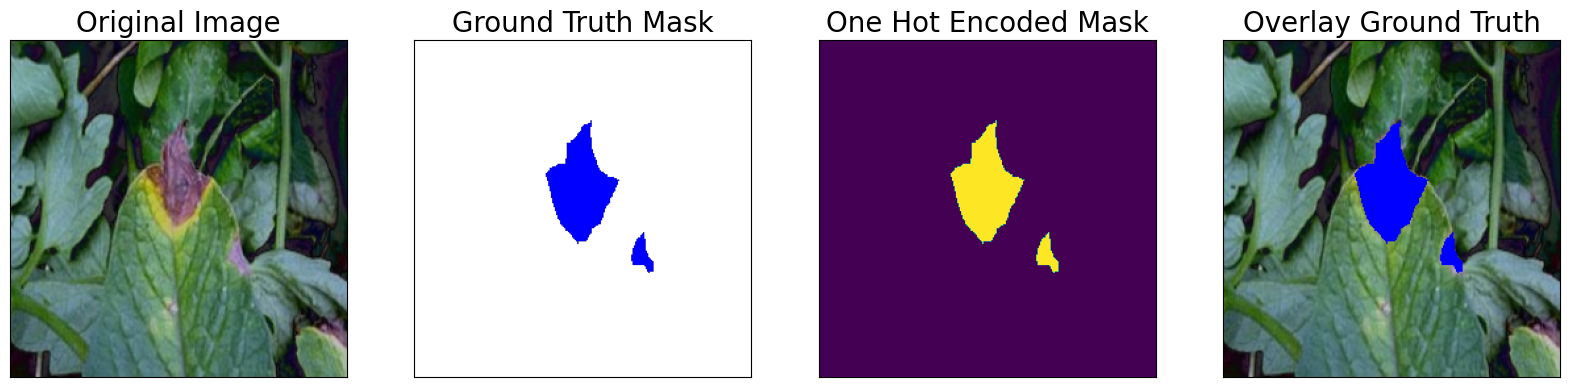

In [ ]:
test_dataloader = DataLoader(test_dataset)

test_dataset_vis = PlantDiseaseDataset(
    test_images, test_masks,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]
ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values)
visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask),
    overlay_ground_truth=overlay_ground_truth(image,ground_truth_mask)

)

In [ ]:
# Define the directory path where sample predictions will be stored
sample_preds_folder = 'sample_predictionss/'

# Check if the directory already exists, if not, create it
if not os.path.exists(sample_preds_folder):
    # Create the directory to store predictions if it does not exist
    os.makedirs(sample_preds_folder)

In [ ]:
sample_preds_folder = 'sample_predictionss/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
len(test_dataset)

235

**show some output samples on test dataset**

In [ ]:
# Loop through the first 10 images in the test dataset
for idx in range(10):
    # Get the image and ground truth mask from the dataset
    image, gt_mask = test_dataset[idx]

    # Crop the image for visualization
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))

    # Convert the image to a tensor and move it to the specified device (GPU or CPU)
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    # Get the predicted mask from the model
    pred_mask = best_model(x_tensor)

    # Detach the prediction from the computation graph, squeeze it to remove extra dimensions, and convert to a numpy array
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()

    # Reorder the dimensions of the predicted mask for proper visualization
    pred_mask = np.transpose(pred_mask, (1, 2, 0))

    # Extract the 'affected' class heatmap from the prediction
    pred_building_heatmap = pred_mask[:, :, select_classes.index('affected')]

    # Perform color coding and reverse one-hot encoding on the predicted mask
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))

    # Reorder and crop the ground truth mask for visualization
    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))

    # Resize the ground truth and predicted masks to match the image size
    gt_mask = cv2.resize(gt_mask[:, :, :3], (image_vis.shape[1], image_vis.shape[0])).astype('uint8')
    pred_mask = cv2.resize(pred_mask[:, :, :3], (image_vis.shape[1], image_vis.shape[0])).astype('uint8')

    # Combine the original image, ground truth mask, and predicted mask horizontally
    combined_image = np.hstack([image_vis, gt_mask, pred_mask])[:, :, ::-1]

    # Save the combined image to the specified folder
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), combined_image)

    # Visualize the original image, ground truth, and predicted masks
    visualize(
        original_image=image_vis,
        ground_truth_mask=gt_mask,
        predicted_mask=pred_mask,
    )

**output mtrics on test data**

In [ ]:
# Initialize the validation epoch for evaluating the model's performance on the test data
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,

# Run the validation on the test dataset and store the results
valid_logs = test_epoch.run(test_dataloader)

# Output the evaluation results (mean IoU and Dice score) to the console
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")


In [ ]:
import pandas as pd

train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
dice_loss,0.236859,0.111639,0.077002,0.064168,0.055616,0.049416,0.044987,0.04341,0.035229,0.032001,...,0.018865,0.018122,0.017322,0.016707,0.016295,0.015836,0.015602,0.015247,0.014814,0.014518
iou_score,0.792437,0.870272,0.891184,0.898905,0.907349,0.914929,0.920513,0.92174,0.935746,0.941043,...,0.963438,0.964833,0.966336,0.967513,0.968278,0.969165,0.969601,0.970254,0.971085,0.971646


**iou score for train and validation over epochs**

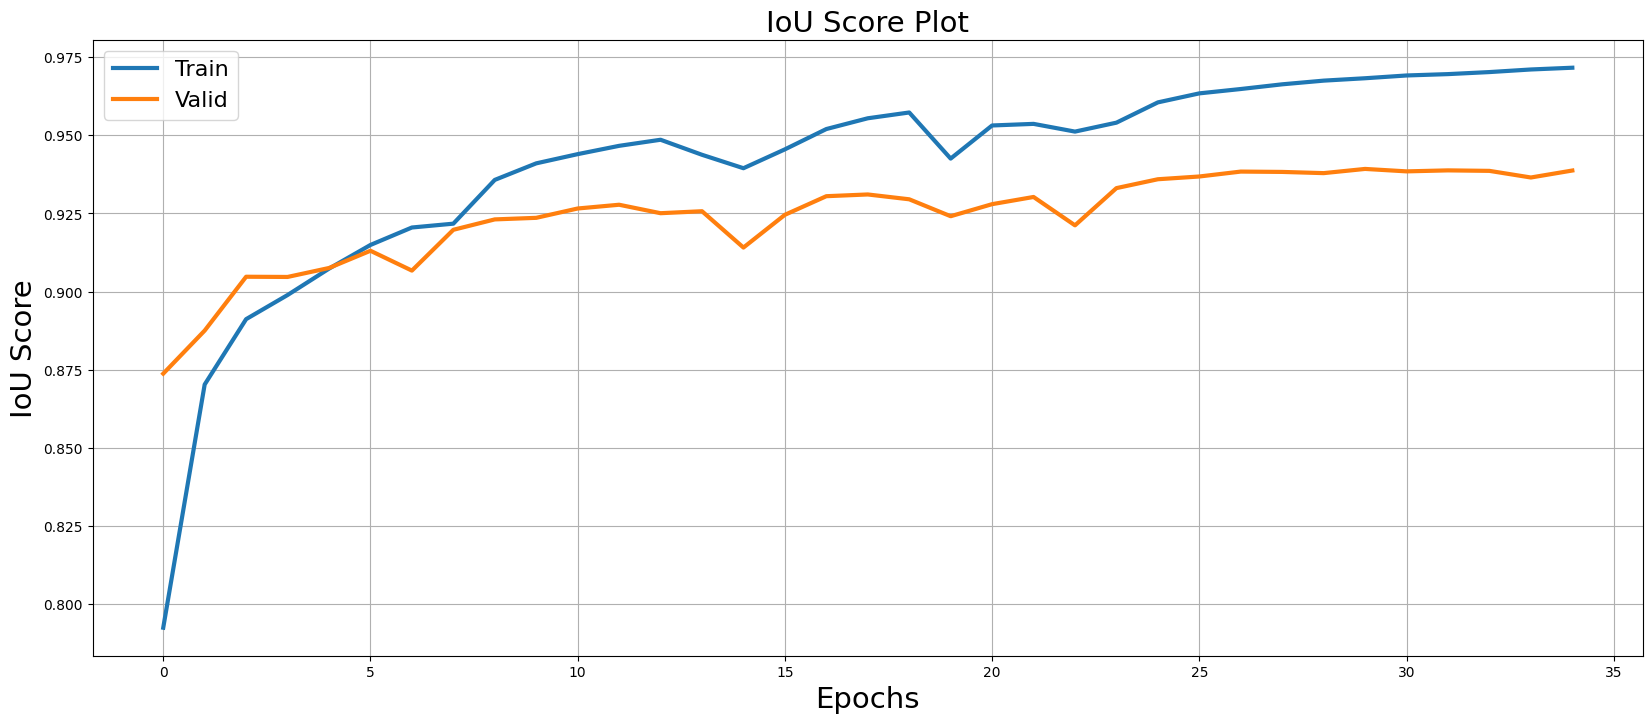

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

**Dice loss for train and validation over epochs**

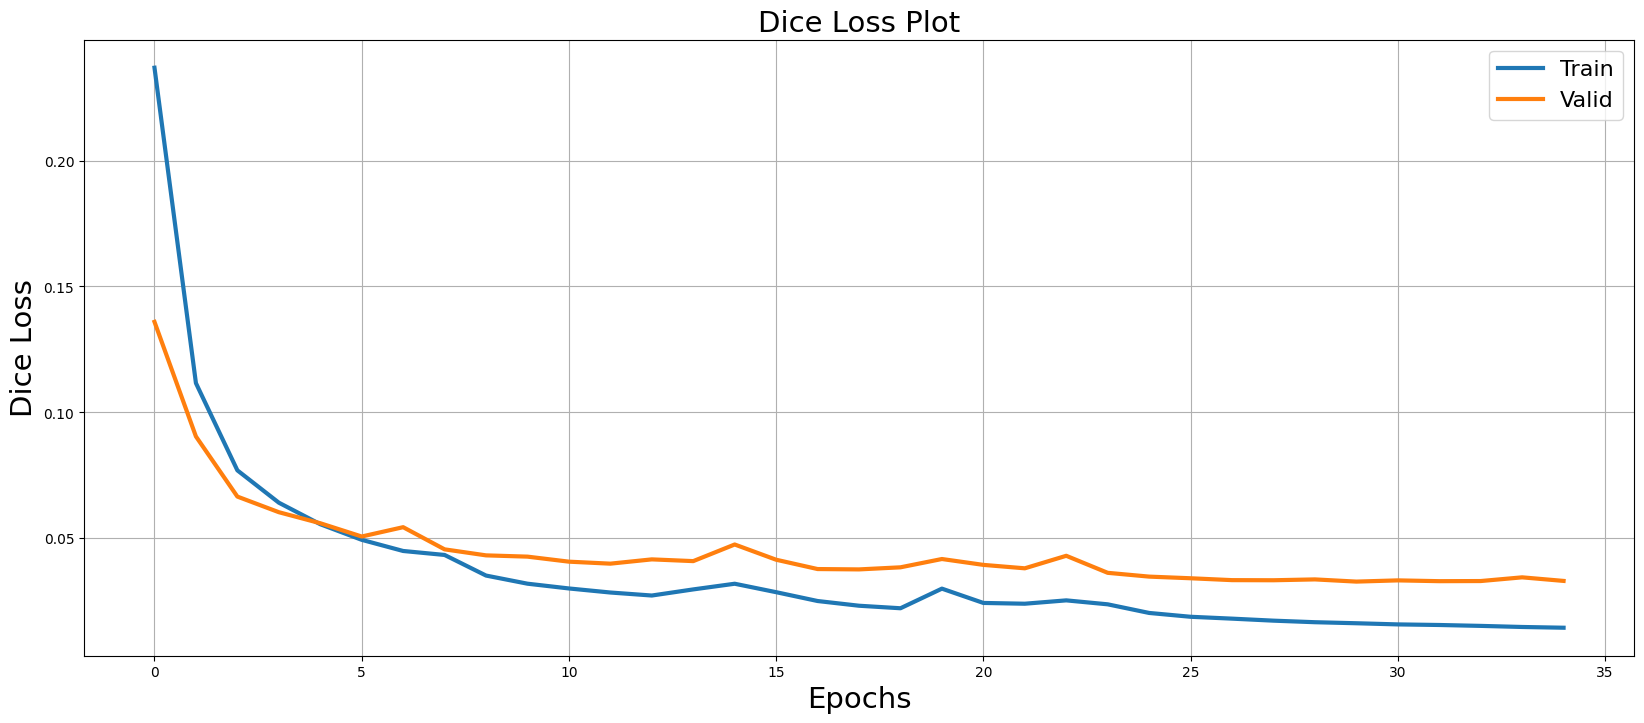

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()